<a href="https://colab.research.google.com/github/rahul17-AI/Rahul/blob/main/lumbarspine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload MRI images


Saving T1_0001_S8.png to T1_0001_S8.png
Upload ground truth images


Saving T1_0001_S8.png to T1_0001_S8 (1).png
Upload pseudo images


Saving T1_0001_S8.png to T1_0001_S8 (2).png
Upload Excel sheet


Saving Spinal Measurements.xlsx to Spinal Measurements.xlsx


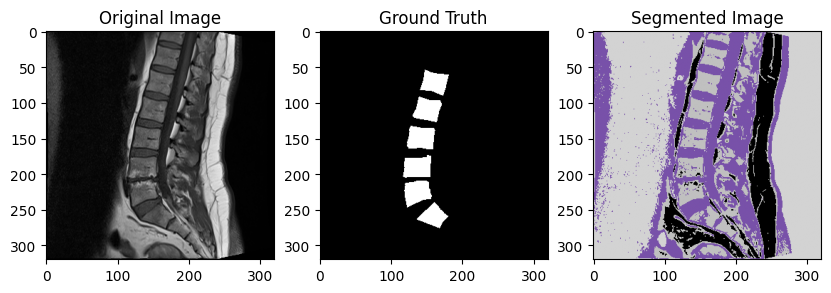

Image 1 - Lordosis Classification: Hyperlordosis
Average Accuracy: 0.501513671875
Average F1 Score: 0.27713700905868444
Average Dice Score: 0.12652652652652652
Average Jaccard Index: 0.19487778458238625
Average IOU Score: 0.19487778458238625
Average Hausdorff Distance: 154.983870128475
CPU Time: 3.8723702430725098 seconds
Max Accuracy: 0.501513671875


In [ ]:
import numpy as np                                          #GMM Algorithm
import matplotlib.pyplot as plt
from skimage import io, color, transform
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from google.colab import files
from matplotlib.colors import ListedColormap
import time
import pandas as pd

# Function to upload images
def upload_images():
    uploaded = files.upload()
    image_paths = list(uploaded.keys())
    return image_paths

# Function to compute Dice score
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

# Function to compute Hausdorff distance
def hausdorff_distance(segmented, ground_truth):
    # Get coordinates of non-zero pixels in both images
    segmented_coords = np.column_stack(np.where(segmented))
    ground_truth_coords = np.column_stack(np.where(ground_truth))
    # Compute directed Hausdorff distances
    forward_hausdorff = directed_hausdorff(segmented_coords, ground_truth_coords)[0]
    reverse_hausdorff = directed_hausdorff(ground_truth_coords, segmented_coords)[0]
    # Return the maximum of the two directed distances
    return max(forward_hausdorff, reverse_hausdorff)

# Function to classify lordosis based on Lumbar Lordotic Angle (LLA)
def classify_lordosis(lla):
    if lla > 45:
        return 'Hyperlordosis'
    elif lla < 20:
        return 'Hypolordosis'
    else:
        return 'Normal'

# Define a custom colormap with distinct colors
custom_colors = ['#D3D3D3', '#C0C0C0', '#7851A9', '#000000']
custom_cmap = ListedColormap(custom_colors)

# Upload images
print("Upload MRI images")
mri_image_paths = upload_images()

print("Upload ground truth images")
ground_truth_image_paths = upload_images()

print("Upload pseudo images")
pseudo_image_paths = upload_images()

# Upload the Excel file containing Lumbar Lordotic Angles
print("Upload Excel sheet")
uploaded_excel = files.upload()
excel_file = list(uploaded_excel.keys())[0]
excel_data = pd.read_excel(excel_file)

# Apply lordosis classification based on the Lumbar Lordotic Angle (LLA)
excel_data['Lordosis Classification'] = excel_data['LumbarLordoticAngle'].apply(classify_lordosis)

num_components = 4  # Number of Gaussian components
accuracies = []
f1_scores = []
dice_scores = []
jaccard_indices = []
iou_scores = []  # Store IoU scores
hausdorff_distances = []
max_accuracy = 0
start_time = time.time()

for i, image_path in enumerate(mri_image_paths):
    # Load the MRI image
    image = io.imread(image_path)

    # Convert to grayscale if the image is in RGB
    if image.shape[-1] == 3:
        image_gray = color.rgb2gray(image)
    else:
        image_gray = image.astype(float)

    # Normalize image pixel values to [0, 1]
    image_gray = image_gray / np.max(image_gray)

    # Flatten the image to feed into GMM
    rows, cols = image_gray.shape
    image_flat = image_gray.flatten().reshape(-1, 1)

    # Initialize Gaussian Mixture Model
    gmm = GaussianMixture(n_components=num_components, random_state=42)

    # Fit GMM on flattened image data
    gmm.fit(image_flat)

    # Predict cluster labels
    predicted_labels = gmm.predict(image_flat)

    # Reshape predicted labels to original image shape
    segmented_image = predicted_labels.reshape(rows, cols)

    # Load ground truth image
    ground_truth = io.imread(ground_truth_image_paths[i])
    if ground_truth.ndim == 3:  # Convert to grayscale if the image is in RGB
        ground_truth = color.rgb2gray(ground_truth)
    ground_truth = ground_truth.astype(int)

    # Resize ground truth to match the dimensions of the segmented image
    ground_truth_resized = transform.resize(ground_truth, segmented_image.shape, mode='constant', preserve_range=True)
    ground_truth_resized = (ground_truth_resized > 0.5).astype(int)  # Ensure binary labels

    # Calculate metrics
    accuracy = accuracy_score(ground_truth_resized.flatten(), segmented_image.flatten())
    accuracies.append(accuracy)
    max_accuracy = max(max_accuracy, accuracy)

    f1 = f1_score(ground_truth_resized.flatten(), segmented_image.flatten(), average='macro')
    f1_scores.append(f1)

    jaccard = jaccard_score(ground_truth_resized.flatten(), segmented_image.flatten(), average='macro')
    jaccard_indices.append(jaccard)

    dice = dice_score(ground_truth_resized.flatten(), segmented_image.flatten())
    dice_scores.append(dice)

    # Calculate IoU Score (same as Jaccard Index)
    iou_scores.append(jaccard)  # IoU and Jaccard are equivalent in this context

    # Calculate Hausdorff distance
    hausdorff_dist = hausdorff_distance(segmented_image, ground_truth_resized)
    hausdorff_distances.append(hausdorff_dist)

    # Display original and segmented images
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_resized, cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image, cmap=custom_cmap)
    plt.title('Segmented Image')
    plt.show()

    # Display classification result based on LLA from Excel
    classification_result = excel_data['Lordosis Classification'][i]
    print(f"Image {i+1} - Lordosis Classification: {classification_result}")

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)
average_dice = np.mean(dice_scores)
average_jaccard = np.mean(jaccard_indices)
average_hausdorff = np.mean(hausdorff_distances)
average_iou = np.mean(iou_scores)  # Calculate average IoU
cpu_time = time.time() - start_time

print(f'Average Accuracy: {average_accuracy}')
print(f'Average F1 Score: {average_f1}')
print(f'Average Dice Score: {average_dice}')
print(f'Average Jaccard Index: {average_jaccard}')
print(f'Average IOU Score: {average_iou}')  # Print average IoU score
print(f'Average Hausdorff Distance: {average_hausdorff}')
print(f'CPU Time: {cpu_time} seconds')
print(f'Max Accuracy: {max_accuracy}')